Diplomatura de Especialización en Desarrollo de Aplicaciones con Inteligencia Artificial 2023-01

Curso: Desarrollo en Aplicaciones con Visión Artificial
Integrantes:
* Girao La Rosa, Jorge
* M. Isabel Ruiz Ruiz

# Leer datos

In [ ]:
import zipfile
import os
import numpy as np
import pathlib
import cv2
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras import layers
import matplotlib.pyplot as plt

try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Cargar archivos

In [ ]:
# Ruta al archivo ZIP en Google Drive
#File path Jorge
#zip_file_path = '/content/drive/MyDrive/PUCP/Diplomados/2023 Inteligencia Artificial/Cursos/Modulo 2/Desarrollo en Aplicaciones con Visión Artificial/Trabajo Final Visión Artificial/X-rays.zip'
#File path Isabel
zip_file_path = '/content/drive/MyDrive/2023 - Diplomatura PUCP AI/4 - DAVA - Vision Artificial/Trabajo Final Visión Artificial/X-rays.zip'

# Directorio donde se extraerán los archivos ZIP
extracted_dir = '/content/extracted/'

# Extraer el archivo ZIP
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_dir)

In [ ]:
# Diviendo la data en entrenamiento y validación
filenames = tf.io.gfile.glob('/content/extracted/chest_xray/train/*/*')
filenames.extend(tf.io.gfile.glob('/content/extracted/chest_xray/val/*/*'))
train_filenames, val_filenames = train_test_split(filenames, test_size=0.2)

# Leyendo los 3 dataset (entrenamiento, validación y pruebas)
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)
test_list_ds = tf.data.Dataset.list_files('/content/extracted/chest_xray/test/*/*')

# Mostrando ejemplos de cada set de datos (entrenamiento, validación y pruebas)
for f in train_list_ds.take(4):
    print(f.numpy())

for f in val_list_ds.take(4):
    print(f.numpy())

for f in test_list_ds.take(4):
    print(f.numpy())

b'/content/extracted/chest_xray/train/PNEUMONIA/person1092_bacteria_3032.jpeg'
b'/content/extracted/chest_xray/train/NORMAL/NORMAL2-IM-0700-0001.jpeg'
b'/content/extracted/chest_xray/train/NORMAL/NORMAL2-IM-0587-0001-0001.jpeg'
b'/content/extracted/chest_xray/train/NORMAL/NORMAL2-IM-0857-0001.jpeg'
b'/content/extracted/chest_xray/train/PNEUMONIA/person461_bacteria_1960.jpeg'
b'/content/extracted/chest_xray/train/PNEUMONIA/person1018_bacteria_2949.jpeg'
b'/content/extracted/chest_xray/train/PNEUMONIA/person574_bacteria_2372.jpeg'
b'/content/extracted/chest_xray/train/NORMAL/IM-0705-0001.jpeg'
b'/content/extracted/chest_xray/test/NORMAL/NORMAL2-IM-0029-0001.jpeg'
b'/content/extracted/chest_xray/test/PNEUMONIA/person29_virus_64.jpeg'
b'/content/extracted/chest_xray/test/NORMAL/NORMAL2-IM-0332-0001.jpeg'
b'/content/extracted/chest_xray/test/PNEUMONIA/person17_virus_48.jpeg'


# Exploración de los datos de entrenamiento

Cantidad de imágenes en cada carpeta
* Imbalance entre el número de imágenes de Rx Normal y Neumonía

In [ ]:
norm_path = pathlib.Path('/content/extracted/chest_xray/train/NORMAL')
pneu_path = pathlib.Path('/content/extracted/chest_xray/train/PNEUMONIA')

initial_count = 0
for path in os.listdir(norm_path):
    if os.path.isfile(os.path.join(norm_path, path)):
        initial_count += 1

print("Archivos en la carpeta train Rx normal:", initial_count)

initial_count = 0
for path in os.listdir(pneu_path):
    if os.path.isfile(os.path.join(pneu_path, path)):
        initial_count += 1

print("Archivos en la carpeta train Rx pneumonia:", initial_count)

Archivos en la carpeta train Rx normal: 1341
Archivos en la carpeta train Rx pneumonia: 3875


In [ ]:
test_norm_path = pathlib.Path('/content/extracted/chest_xray/test/NORMAL')
tes_pneu_path = pathlib.Path('/content/extracted/chest_xray/test/PNEUMONIA')

initial_count = 0
for path in os.listdir(test_norm_path):
    if os.path.isfile(os.path.join(test_norm_path, path)):
        initial_count += 1

print("Archivos en la carpeta test Rx normal:", initial_count)

initial_count = 0
for path in os.listdir(tes_pneu_path):
    if os.path.isfile(os.path.join(tes_pneu_path, path)):
        initial_count += 1

print("Archivos en la carpeta test Rx pneumonia:", initial_count)

Archivos en la carpeta test Rx normal: 234
Archivos en la carpeta test Rx pneumonia: 390


In [ ]:
val_norm_path = pathlib.Path('/content/extracted/chest_xray/val/NORMAL')
val_pneu_path = pathlib.Path('/content/extracted/chest_xray/val/PNEUMONIA')

initial_count = 0
for path in os.listdir(val_norm_path):
    if os.path.isfile(os.path.join(val_norm_path, path)):
        initial_count += 1

print("Archivos en la carpeta val Rx normal:", initial_count)

initial_count = 0
for path in os.listdir(val_pneu_path):
    if os.path.isfile(os.path.join(val_pneu_path, path)):
        initial_count += 1

print("Archivos en la carpeta val Rx pneumonia:", initial_count)

Archivos en la carpeta val Rx normal: 8
Archivos en la carpeta val Rx pneumonia: 8


¿Datos duplicados? NO

In [ ]:
def check_duplicate_image(path):
        image_filenames = [image.name for image in  path.glob('*.jpeg')]

        filename_counts = {}

        for filename in image_filenames:
            if filename in filename_counts:
                filename_counts[filename] += 1
            else:
                filename_counts[filename] = 1

        duplicate_filenames = [filename for filename, count in filename_counts.items() if count > 1]

        if duplicate_filenames:
            print("Duplicate image filenames:")
            for duplicate_filename in duplicate_filenames:
                print(duplicate_filename)
        else:
            print("No duplicate image filenames .")

In [ ]:
print(check_duplicate_image(norm_path))
print(check_duplicate_image(pneu_path))

No duplicate image filenames .
None
No duplicate image filenames .
None


¿Diferentes formatos de imágenes? NO

In [ ]:
def differnt_type_image(path):
    subdirectories = [subdir.name for subdir in path.glob('*') if subdir.is_dir()]

    num_image_types = len(subdirectories)

    print("Number of different types of images:", num_image_types)
    print("Types of images:", subdirectories)

In [ ]:
print(differnt_type_image(norm_path))
print(differnt_type_image(pneu_path))

Number of different types of images: 0
Types of images: []
None
Number of different types of images: 0
Types of images: []
None


¿Diferente cantidad de datos? SÍ
* Imbalance de datos entre el set normal y neumonía
* Problema con el nombre de los archivos, si se lee a partir del nombre de los archivos se considera un menor número, pero se mantiene el imbalance.

In [ ]:
print(train_filenames)

['/content/extracted/chest_xray/train/PNEUMONIA/person1092_bacteria_3032.jpeg', '/content/extracted/chest_xray/train/NORMAL/NORMAL2-IM-0700-0001.jpeg', '/content/extracted/chest_xray/train/NORMAL/NORMAL2-IM-0587-0001-0001.jpeg', '/content/extracted/chest_xray/train/NORMAL/NORMAL2-IM-0857-0001.jpeg', '/content/extracted/chest_xray/train/NORMAL/IM-0210-0001.jpeg', '/content/extracted/chest_xray/train/NORMAL/NORMAL2-IM-0635-0001.jpeg', '/content/extracted/chest_xray/train/NORMAL/IM-0718-0001.jpeg', '/content/extracted/chest_xray/train/NORMAL/NORMAL2-IM-0705-0001.jpeg', '/content/extracted/chest_xray/train/PNEUMONIA/person647_virus_1228.jpeg', '/content/extracted/chest_xray/train/PNEUMONIA/person25_bacteria_121.jpeg', '/content/extracted/chest_xray/train/PNEUMONIA/person1730_bacteria_4559.jpeg', '/content/extracted/chest_xray/train/PNEUMONIA/person858_bacteria_2780.jpeg', '/content/extracted/chest_xray/train/PNEUMONIA/person837_virus_1475.jpeg', '/content/extracted/chest_xray/train/NORMAL/

In [ ]:
contImgTrain = tf.data.experimental.cardinality(train_list_ds).numpy()
contImgVal = tf.data.experimental.cardinality(val_list_ds).numpy()

contadorNormal = len([filename for filename in train_filenames if "NORMAL" in filename])
print("Cantidad de imágenes normales en el conjunto de entrenamiento: " + str(contadorNormal))

contadorNeumonia = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print("Cantidad de imágenes con neumonía en el conjunto de entrenamiento: " + str(contadorNeumonia))

contadorNeuBac = len([filename for filename in train_filenames if "bacteria" in filename])
print("Cantidad de imágenes con neumonía bacteriana en el conjunto de entrenamiento: " + str(contadorNeuBac))

contadorNeuVir = len([filename for filename in train_filenames if "virus" in filename])
print("Cantidad de imágenes con neumonía viral en el conjunto de entrenamiento: " + str(contadorNeuVir))

Cantidad de imágenes normales en el conjunto de entrenamiento: 1081
Cantidad de imágenes con neumonía en el conjunto de entrenamiento: 3104
Cantidad de imágenes con neumonía bacteriana en el conjunto de entrenamiento: 2028
Cantidad de imágenes con neumonía viral en el conjunto de entrenamiento: 1076


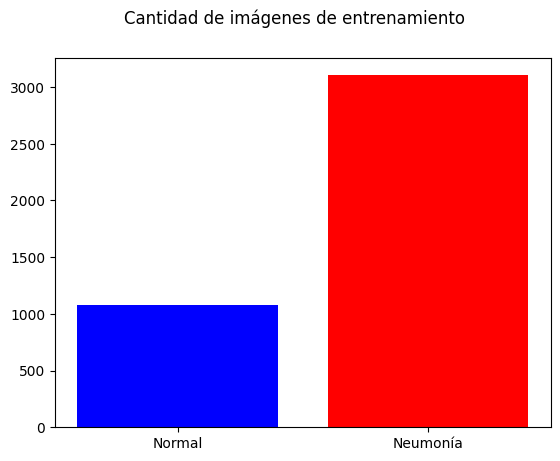

In [ ]:
names = ['Normal', 'Neumonía']
values = [contadorNormal, contadorNeumonia]
colors = ['blue', 'red']

plt.plot(131)
plt.bar(names, values, color = colors)
plt.suptitle('Cantidad de imágenes de entrenamiento')
plt.show()

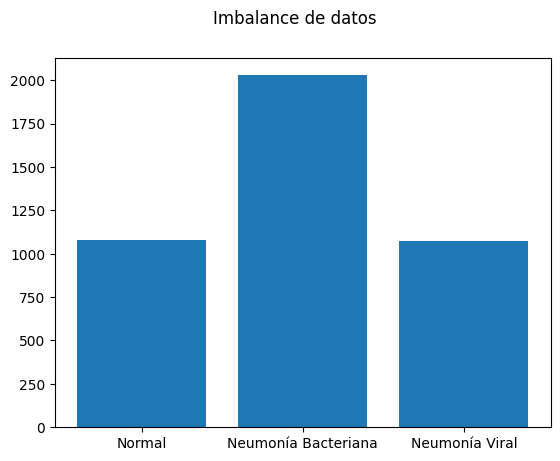

In [ ]:
#Gráfico alternativo
names = ['Normal','Neumonía Bacteriana', 'Neumonía Viral']
values = [contadorNormal, contadorNeuBac, contadorNeuVir]

plt.plot(131)
plt.bar(names, values)
plt.suptitle('Imbalance de datos')
plt.show()

Hay más imágenes de neumonía que pulmones sanos y normales en el conjunto de entrenamiento (imbalance de datos). Más adelante lo solucionaremos con la técnica de Data Augmentation.

¿Diferente resolución de imágenes? SÍ

In [ ]:
def plot_distribation_width_height(widths , heights ):
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.hist(widths, bins=20, color='blue', alpha=0.7)
    plt.xlabel('Image Width')
    plt.ylabel('Frequency')
    plt.title('Distribution of Image Widths')

    plt.subplot(1, 2, 2)
    plt.hist(heights, bins=20, color='green', alpha=0.7)
    plt.xlabel('Image Height')
    plt.ylabel('Frequency')
    plt.title('Distribution of Image Heights')

    plt.tight_layout()
    plt.show()


In [ ]:
def plot_bytes_distrubation(image_sizes):
    plt.hist(image_sizes, bins=20, color='red', alpha=0.7)
    plt.xlabel('Image Size (Bytes)')
    plt.ylabel('Frequency')
    plt.title('Distribution of Image Sizes (Bytes)')

In [ ]:
train_data = [norm_path , pneu_path ]

In [ ]:
import PIL
import PIL.Image
from PIL import Image

train_data = [norm_path , pneu_path ]
train_widths = []
train_hieghts = []
train_Imgsize = []

for path in train_data:
    image_files = list(path.glob('**/*.jpeg'))

    widths = []
    heights = []
    image_sizes = []

    for image_file in image_files:
        size_bytes = os.path.getsize(image_file)
        image_sizes.append(size_bytes)
        with Image.open(image_file) as img:
            width, height = img.size
            widths.append(width)
            heights.append(height)


    train_widths.append(widths)
    train_hieghts.append(heights)
    train_Imgsize.append(image_sizes)

Normal

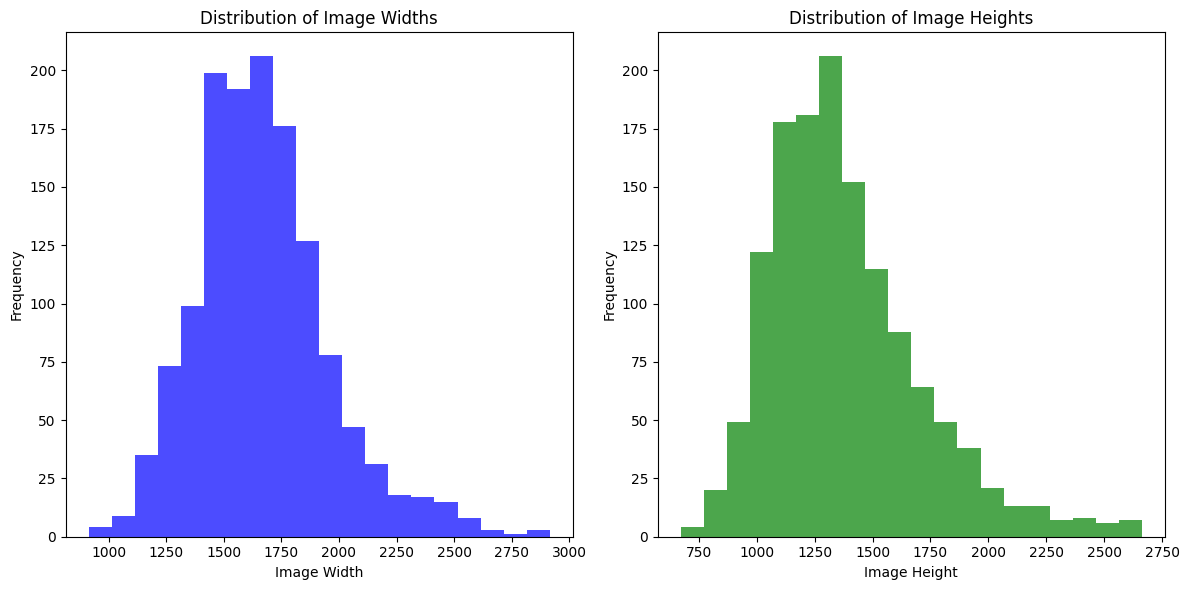

In [ ]:
#Normal images distribution
plot_distribation_width_height(train_widths[0] , train_hieghts[0] , )

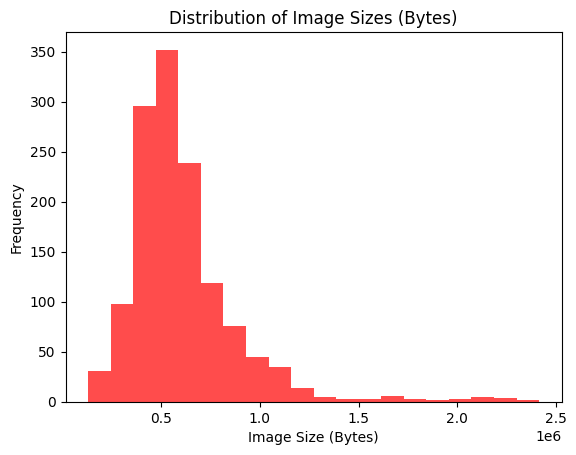

In [ ]:
plot_bytes_distrubation(train_Imgsize[0])

Pneumonia

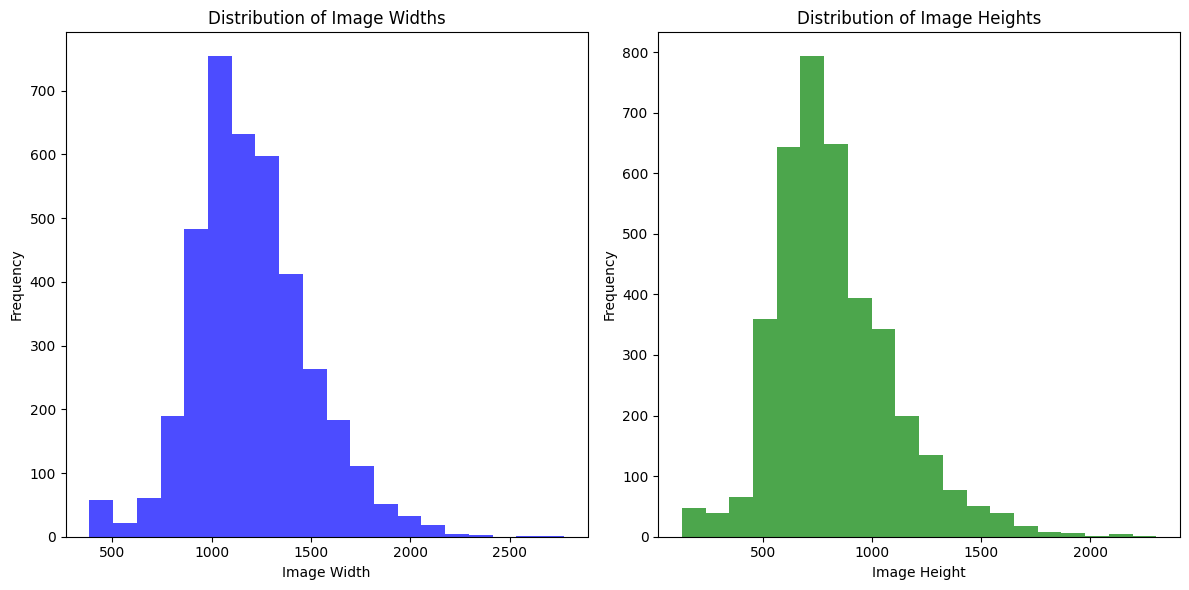

In [ ]:
plot_distribation_width_height(train_widths[1] , train_hieghts[1]  )

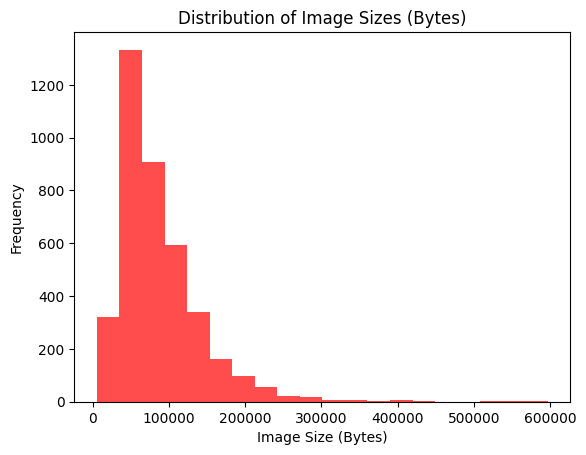

In [ ]:
plot_bytes_distrubation(train_Imgsize[1])


Resolución de la imagen

In [ ]:
train_widths = []
train_heights = []
train_Imgsize = []
label_name = []
image_paths = []  # Create a list to store the image file paths

for  path in train_data:
    image_files =  list(path.glob('**/*.jpeg'))
    for image_file in image_files:
        size_bytes = os.path.getsize(image_file)
        train_Imgsize.append(size_bytes)
        relative_path = os.path.relpath(image_file, path)
        image_paths.append(path.name + "/"+ relative_path)
        with Image.open(image_file) as img:
            width, height = img.size
            train_widths.append(width)
            train_heights.append(height)
            label_name.append( path.name )

In [ ]:
import pandas as pd
widths_df = pd.DataFrame({'Widths': train_widths})
heights_df = pd.DataFrame({'Heights': train_heights})
imgsize_df = pd.DataFrame({'ImgSize': train_Imgsize}) #bytes of the picture
label_df = pd.DataFrame({'label': label_name})
imgpath_df = pd.DataFrame({'image_paths' :image_paths })
# if that's what you want.
df = pd.concat([widths_df, heights_df, imgsize_df , label_df , imgpath_df ], axis=1)

print(df.head())

   Widths  Heights  ImgSize   label                       image_paths
0    2302     1514   878084  NORMAL  NORMAL/NORMAL2-IM-0417-0001.jpeg
1    1198      978   290755  NORMAL          NORMAL/IM-0750-0001.jpeg
2    1088      824   152208  NORMAL  NORMAL/NORMAL2-IM-0725-0001.jpeg
3    1982     1804   806211  NORMAL          NORMAL/IM-0286-0001.jpeg
4    2252     1913  1324376  NORMAL          NORMAL/IM-0766-0001.jpeg


In [ ]:
df['Aspect_Ratio'] =  round(widths_df['Widths'] / heights_df['Heights'] , 2 )
df

,Widths,Heights,ImgSize,label,image_paths,Aspect_Ratio
0,2302,1514,878084,NORMAL,NORMAL/NORMAL2-IM-0417-0001.jpeg,1.52
1,1198,978,290755,NORMAL,NORMAL/IM-0750-0001.jpeg,1.22
2,1088,824,152208,NORMAL,NORMAL/NORMAL2-IM-0725-0001.jpeg,1.32
3,1982,1804,806211,NORMAL,NORMAL/IM-0286-0001.jpeg,1.10
4,2252,1913,1324376,NORMAL,NORMAL/IM-0766-0001.jpeg,1.18
...,...,...,...,...,...,...
5211,1192,984,80204,PNEUMONIA,PNEUMONIA/person55_bacteria_262.jpeg,1.21
5212,942,571,59684,PNEUMONIA,PNEUMONIA/person887_bacteria_2811.jpeg,1.65
5213,1424,1056,98537,PNEUMONIA,PNEUMONIA/person443_bacteria_1924.jpeg,1.35
5214,1184,816,76402,PNEUMONIA,PNEUMONIA/person1717_bacteria_4534.jpeg,1.45


In [ ]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)

# Define colors based on the 'label' column (0 or 1)
colors = np.where(df['label'] == "NORMAL", 'blue', 'red')

points = ax.scatter(df.Widths, df.Heights, color=colors, alpha=0.5, s=df["Aspect_Ratio"] * 100, picker=True)

ax.set_title("Image Resolution")
ax.set_xlabel("Width", size=14)
ax.set_ylabel("Height", size=14)
plt.show()

In [ ]:
df['label'].value_counts()

PNEUMONIA    3875
NORMAL       1341
Name: label, dtype: int64

Distribución del tamaño de las imágenes

Text(0, 0.5, 'Count')

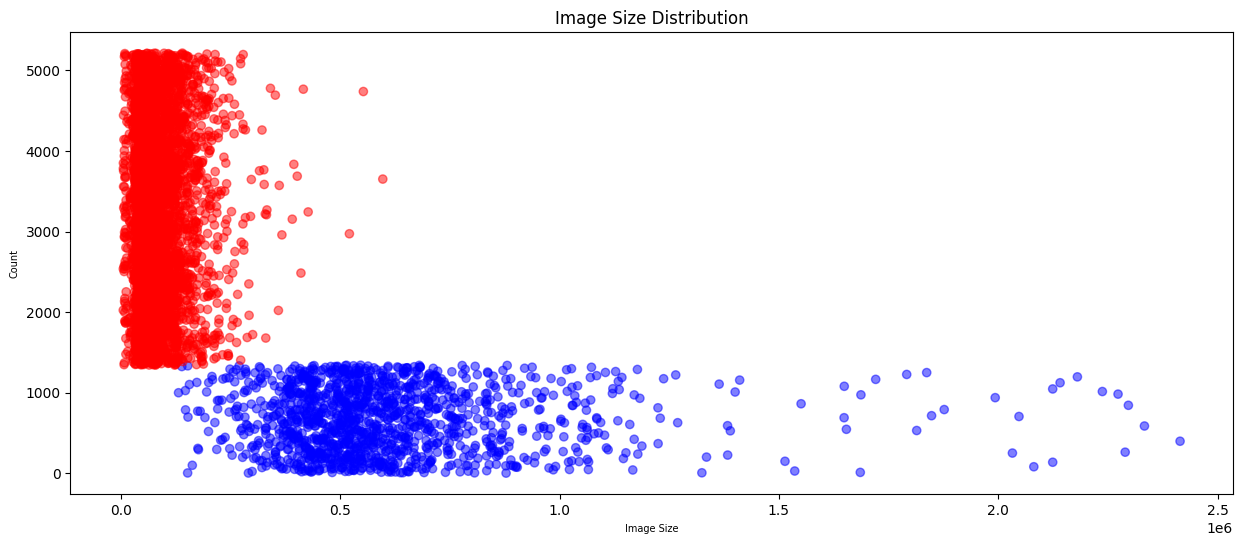

In [ ]:
# Group by 'ImgSize' and count occurrences
size_counts = df.groupby('ImgSize').size().reset_index(name='Count')

# Scatter plot
fig = plt.figure(figsize=(15, 6))
ax = fig.add_subplot(111)

# Define colors based on the 'label' column (0 or 1)
colors = np.where(df['label'] == "NORMAL", 'blue', 'red')

ax.scatter( df.ImgSize ,  df.index , color=colors, alpha=0.5)
ax.set_title("Image Size Distribution")
ax.set_xlabel("Image Size", size=7)
ax.set_ylabel("Count", size=7)

Text(0, 0.5, 'Count')

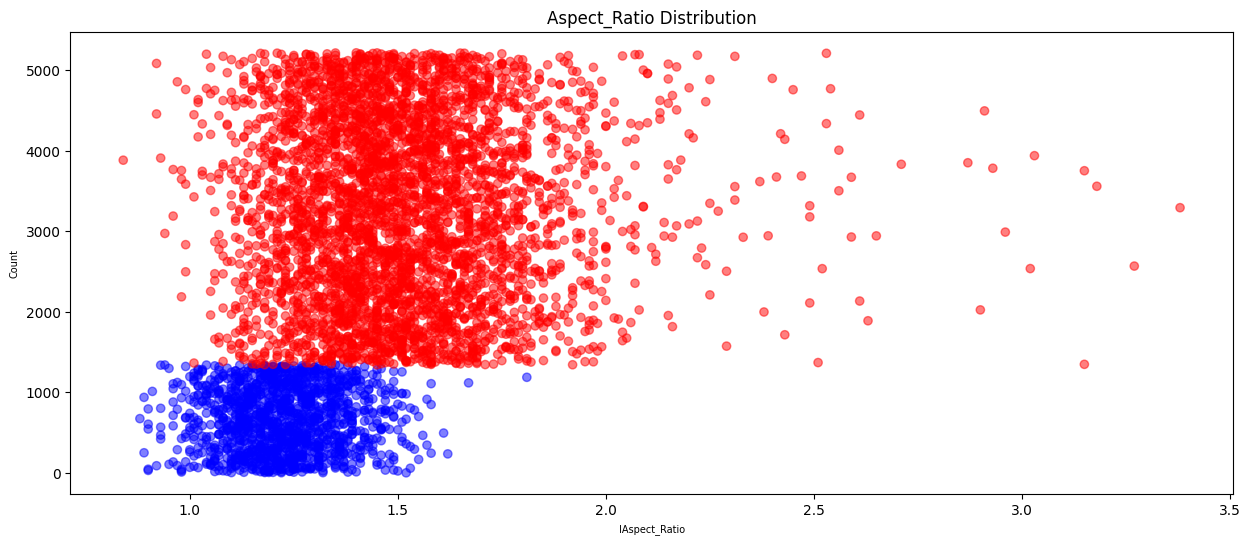

In [ ]:
# Group by 'ImgSize' and count occurrences
size_counts = df.groupby('Aspect_Ratio').size().reset_index(name='Count')

# Scatter plot
fig = plt.figure(figsize=(15, 6))
ax = fig.add_subplot(111)

# Define colors based on the 'label' column (0 or 1)
colors = np.where(df['label'] == "NORMAL", 'blue', 'red')

ax.scatter( df.Aspect_Ratio ,  df.index , color=colors, alpha=0.5)
ax.set_title("Aspect_Ratio Distribution")
ax.set_xlabel("IAspect_Ratio", size=7)
ax.set_ylabel("Count", size=7)

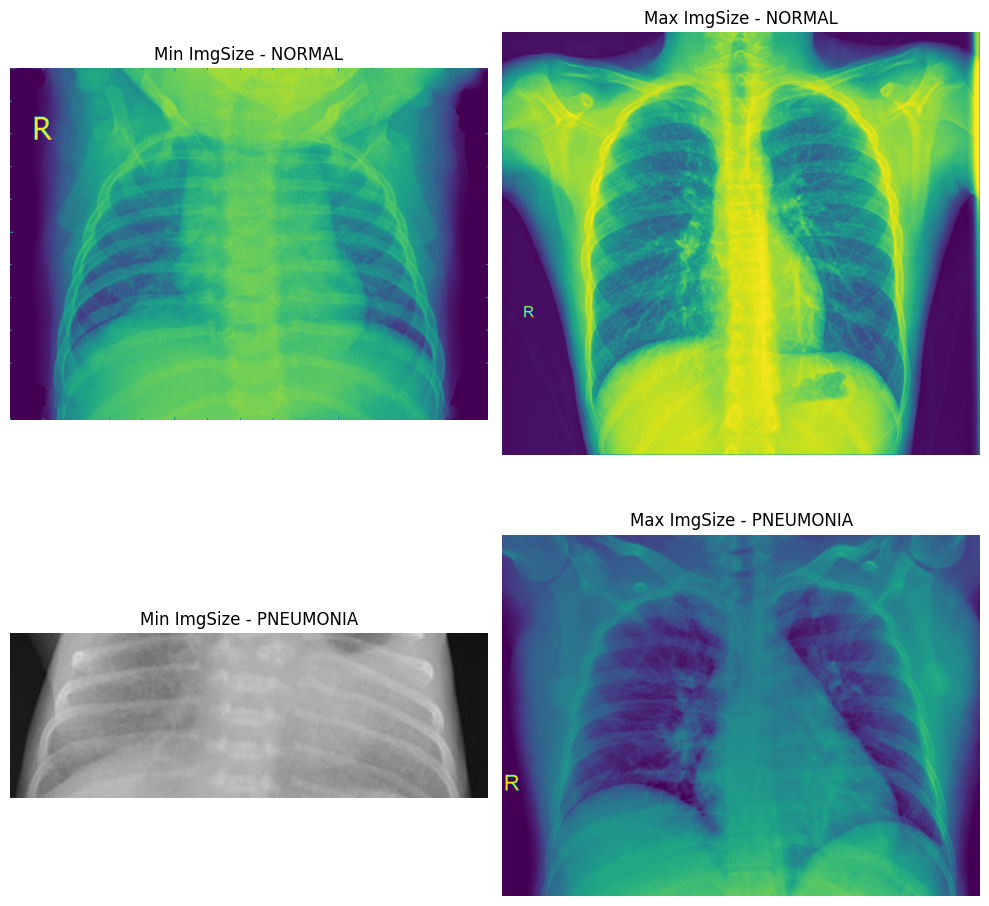

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd

main_path = "/content/extracted/chest_xray/train"

# Assuming you have a DataFrame named 'df' with your dataset

# Filter rows for 'NORMAL' and 'PNEUMONIA' labels
normal_rows = df[df['label'] == 'NORMAL']
pneumonia_rows = df[df['label'] == 'PNEUMONIA']

# Find rows with the minimum and maximum 'ImgSize' values for each label
min_normal_row = normal_rows[normal_rows['ImgSize'] == normal_rows['ImgSize'].min()]
max_normal_row = normal_rows[normal_rows['ImgSize'] == normal_rows['ImgSize'].max()]
min_pneumonia_row = pneumonia_rows[pneumonia_rows['ImgSize'] == pneumonia_rows['ImgSize'].min()]
max_pneumonia_row = pneumonia_rows[pneumonia_rows['ImgSize'] == pneumonia_rows['ImgSize'].max()]

# Get the image paths for these rows
min_normal_path = min_normal_row['image_paths'].values[0]
max_normal_path = max_normal_row['image_paths'].values[0]
min_pneumonia_path = min_pneumonia_row['image_paths'].values[0]
max_pneumonia_path = max_pneumonia_row['image_paths'].values[0]

# Load and plot the images
fig, axes = plt.subplots(2, 2, figsize=(10, 10))
axes[0, 0].imshow(Image.open(main_path +"/"+min_normal_path))
axes[0, 0].set_title(f"Min ImgSize - NORMAL")
axes[0, 1].imshow(Image.open(main_path +"/"+max_normal_path))
axes[0, 1].set_title(f"Max ImgSize - NORMAL")
axes[1, 0].imshow(Image.open(main_path +"/"+min_pneumonia_path))
axes[1, 0].set_title(f"Min ImgSize - PNEUMONIA")
axes[1, 1].imshow(Image.open(main_path +"/"+max_pneumonia_path))
axes[1, 1].set_title(f"Max ImgSize - PNEUMONIA")

for ax in axes.ravel():
    ax.axis('off')

plt.tight_layout()
plt.show()

Contamos con imágenes de distintos tamaños en peso y dimensión (alto x ancho).

Opciones:
- ¿Eliminar outliers?
- ¿Realizar transformaciones?
 - Normalizar tamaño

# Visualizar los datos

In [ ]:
tamanho_Imagen = [180, 180]
contrast_factor = 1.5
delta = 0.1
tamanho_Batch = 16 * strategy.num_replicas_in_sync

In [ ]:
# CNN funciona mejor con imágenes más pequeñas, por eso las reduciremos
def decode_img(img):
  img = tf.image.decode_jpeg(img, channels=3)
  #img = tf.image.rgb_to_grayscale(img, name=None)
  img = tf.image.convert_image_dtype(img, tf.float32)
  img = tf.image.adjust_contrast(img, contrast_factor)
  #img = tf.image.adjust_brightness(img, delta)
  return tf.image.resize(img, tamanho_Imagen)

In [ ]:
# Asignando cada imagen con su nombre de archivo
def process_path(file_path):
    label = tf.strings.split(file_path, os.path.sep)[-2] == "PNEUMONIA"
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label

In [ ]:
# Asignando cada imagen con su nombre de archivo
train_ds = train_list_ds.map(process_path, num_parallel_calls=tf.data.experimental.AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test_ds = test_list_ds.map(process_path, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test_ds = test_ds.batch(tamanho_Batch)

# Mostrando un elemento del dataset de entrenamiento con su imagen y su label
for image, label in train_ds.take(1):
    print("Image shape train dataset: ", image.numpy().shape)
    print("Label: ", label.numpy())

# Mostrando un elemento del dataset de entrenamiento con su imagen y su label
for image, label in test_ds.take(1):
    print("Image shape test dataset: ", image.numpy().shape)
    print("Label: ", label.numpy())

# Mostrando un elemento del dataset de entrenamiento con su imagen y su label
for image, label in val_ds.take(1):
    print("Image shape validation dataset: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape train dataset:  (180, 180, 3)
Label:  True
Image shape test dataset:  (16, 180, 180, 3)
Label:  [False  True  True False False  True  True  True  True False  True False
 False False False False]
Image shape validation dataset:  (180, 180, 3)
Label:  True


In [ ]:
def prepare_for_training(ds, cache=True, shuffle_buffer_size=1000):
    # Almacenando en caché el trabajo de preprocesamiento de conjuntos de datos que no caben en la memoria
    if cache:
        if isinstance(cache, str):
            ds = ds.cache(cache)
        else:
            ds = ds.cache()

    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(tamanho_Batch)
    # Obteniendo lotes en segundo plano mientras el modelo se entrena
    ds = ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

    return ds

In [ ]:
train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

image_batch, label_batch = next(iter(train_ds))

In [ ]:
def mostrar_bloque_imagenes(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(tamanho_Batch):
        ax = plt.subplot(4,4,n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("Neumonía")
        else:
            plt.title("Normal")
        plt.axis("off")

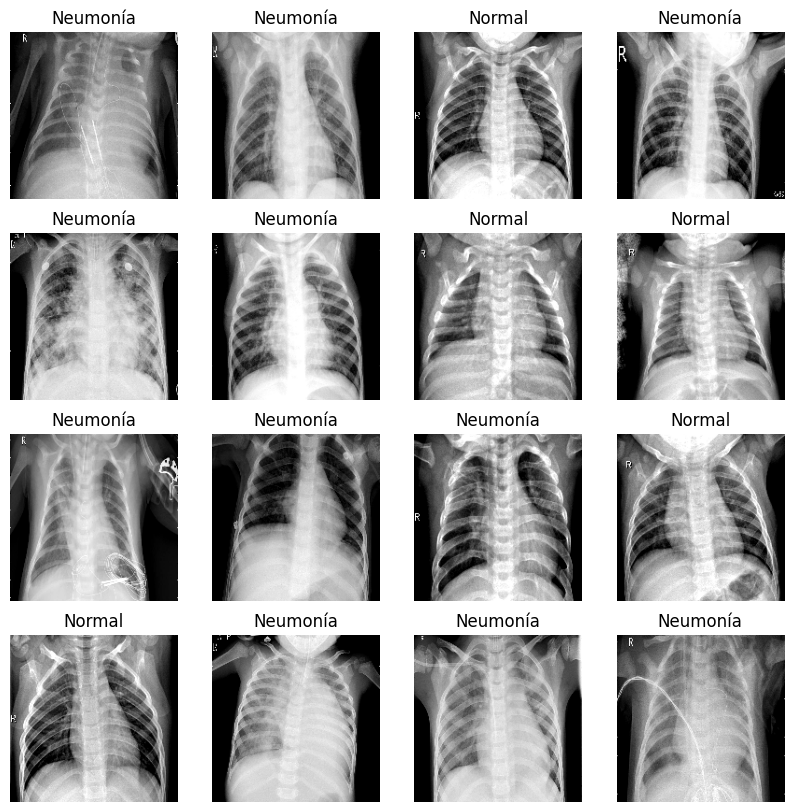

In [ ]:
mostrar_bloque_imagenes(image_batch.numpy(), label_batch.numpy())

# Corrigiendo imbalance de datos

Para solucionar el imbalance de datos utilizaremos la técnica de ***Data Augmentation*** en el conjunto de entrenamiento:

In [ ]:
def augment_image(image, label):
    # Random Flip Horizonal
    image = tf.image.random_flip_left_right(image)
    # Brillo
    image = tf.image.random_brightness(image, max_delta=0.2)
    # Rotación aleatoria de 0 a 180
    angle = tf.random.uniform([], minval=-0.3, maxval=0.3)
    image = tf.image.rot90(image, k=tf.cast(angle / (2 * 0.3), tf.int32))

    # Zoom aleatorio
    #zoom_factor = tf.random.uniform([], minval=0.8, maxval=1.2)  # Rango de zoom del 80% al 120%
    #image = tf.image.resize(image, tf.cast(tf.shape(image)[:2], tf.float32) * zoom_factor)

    # Definir el rango de traslación (0.1 representa un 10% del tamaño de la imagen)
    #translation_pixels = tf.cast(0.1 * tf.minimum(180, 180), tf.int32)

    # Generar traslaciones aleatorias en ambas direcciones
    #horizontal_translation = tf.random.uniform(shape=[], minval=-translation_pixels, maxval=translation_pixels, dtype=tf.int32)
    #vertical_translation = tf.random.uniform(shape=[], minval=-translation_pixels, maxval=translation_pixels, dtype=tf.int32)

    # Aplicar traslación aleatoria
    #image = tf.roll(image, shift=[vertical_translation, horizontal_translation], axis=[0, 1])

    #featurewise_center=False,  # set input mean to 0 over the dataset
    #samplewise_center=False,  # set each sample mean to 0
    #featurewise_std_normalization=False,  # divide inputs by std of the dataset
    #samplewise_std_normalization=False,  # divide each input by its std
    #zca_whitening=False,  # apply ZCA whitening

    #layers.experimental.preprocessing.RandomZoom(0.2),                 # Randomly zoom images
    #layers.experimental.preprocessing.RandomTranslation(0.1, 0.1),      # Randomly shift images horizontally and vertically

    return image, label

# Aplicar data augmentation al conjunto de datos
train_ds = train_ds.map(augment_image)

In [ ]:
# Convierte el conjunto de datos en una lista
# Nota: este proceso consume mucha RAM y necesita una suscripción Colab Pro
#data_list = list(train_ds.as_numpy_iterator())

# Identifica y cuenta las clases únicas en el conjunto de datos
#unique_classes = set(data_list)
#print("Tipos de clases en el conjunto de datos:", unique_classes)

# Construyendo modelo CNN

In [ ]:
model = Sequential()
# Capa convolucional 1
model.add(layers.Conv2D(32, (3, 3), strides=1, padding='same', activation='relu', input_shape=(180, 180, 3)))
model.add(layers.BatchNormalization())
model.add(layers.MaxPool2D((2, 2), strides=2, padding='same'))
# Capa convolucional 2
model.add(layers.Conv2D(64, (3, 3), strides=1, padding='same', activation='relu'))
model.add(layers.Dropout(0.1))
model.add(layers.BatchNormalization())
model.add(layers.MaxPool2D((2, 2), strides=2, padding='same'))
# Capa convolucional 3
model.add(layers.Conv2D(64, (3, 3), strides=1, padding='same', activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPool2D((2, 2), strides=2, padding='same'))
# Capa convolucional 4
model.add(layers.Conv2D(128, (3, 3), strides=1, padding='same', activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.BatchNormalization())
model.add(layers.MaxPool2D((2, 2), strides=2, padding='same'))
# Capa convolucional 5
model.add(layers.Conv2D(256, (3, 3), strides=1, padding='same', activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.BatchNormalization())
model.add(layers.MaxPool2D((2, 2), strides=2, padding='same'))
# Capa Flatten
model.add(layers.Flatten())
# Capa Fully Connected
model.add(layers.Dense(units=128, activation='relu'))
model.add(layers.Dropout(0.2))
# Capa Output
model.add(layers.Dense(units=1, activation='sigmoid'))

# Compilar el modelo
model.compile(optimizer="rmsprop", loss='binary_crossentropy', metrics=['accuracy'])

# Entrenar el modelo
history = model.fit(train_ds,
                    steps_per_epoch = contImgTrain // tamanho_Batch,
                    epochs = 10,
                    validation_data = val_ds,
                    validation_steps = contImgVal // tamanho_Batch)

#Nota: exactitud 98% train, 79% test

Epoch 1/10
261/261 [==============================] - 18s 49ms/step - loss: 0.4702 - accuracy: 0.8882 - val_loss: 30.5499 - val_accuracy: 0.7442
Epoch 2/10
261/261 [==============================] - 13s 49ms/step - loss: 0.1766 - accuracy: 0.9466 - val_loss: 2.5776 - val_accuracy: 0.8250
Epoch 3/10
261/261 [==============================] - 13s 49ms/step - loss: 0.1541 - accuracy: 0.9574 - val_loss: 0.4413 - val_accuracy: 0.7798
Epoch 4/10
261/261 [==============================] - 13s 49ms/step - loss: 0.1274 - accuracy: 0.9650 - val_loss: 1.1043 - val_accuracy: 0.8279
Epoch 5/10
261/261 [==============================] - 13s 48ms/step - loss: 0.0866 - accuracy: 0.9739 - val_loss: 0.2250 - val_accuracy: 0.8952
Epoch 6/10
261/261 [==============================] - 13s 49ms/step - loss: 0.0919 - accuracy: 0.9703 - val_loss: 0.2965 - val_accuracy: 0.9096
Epoch 7/10
261/261 [==============================] - 13s 48ms/step - loss: 0.0737 - accuracy: 0.9770 - val_loss: 0.0397 - val_accuracy

In [ ]:
predictions = model.predict(test_ds)

39/39 [==============================] - 12s 299ms/step


In [ ]:
loss, acc = model.evaluate(test_ds)

39/39 [==============================] - 12s 302ms/step - loss: 1.2560 - accuracy: 0.7660


## Otros modelos CNN (opcional)

### CNN de 7 capas con Optimizador Adam

In [ ]:
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(180, 180, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

# Compilar el modelo
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# Entrenar el modelo
history = model.fit(train_ds,
                    steps_per_epoch = contImgTrain // tamanho_Batch,
                    epochs = 10,
                    validation_data = val_ds,
                    validation_steps = contImgVal // tamanho_Batch)

Epoch 1/10
261/261 [==============================] - 100s 307ms/step - loss: 0.3201 - accuracy: 0.8762 - val_loss: 0.1319 - val_accuracy: 0.9452
Epoch 2/10
261/261 [==============================] - 6s 22ms/step - loss: 0.1370 - accuracy: 0.9480 - val_loss: 0.0936 - val_accuracy: 0.9615
Epoch 3/10
261/261 [==============================] - 7s 26ms/step - loss: 0.1065 - accuracy: 0.9586 - val_loss: 0.1007 - val_accuracy: 0.9615
Epoch 4/10
261/261 [==============================] - 6s 22ms/step - loss: 0.1034 - accuracy: 0.9612 - val_loss: 0.0881 - val_accuracy: 0.9673
Epoch 5/10
261/261 [==============================] - 7s 25ms/step - loss: 0.0959 - accuracy: 0.9641 - val_loss: 0.0937 - val_accuracy: 0.9606
Epoch 6/10
261/261 [==============================] - 6s 22ms/step - loss: 0.0822 - accuracy: 0.9713 - val_loss: 0.1641 - val_accuracy: 0.9346
Epoch 7/10
261/261 [==============================] - 6s 22ms/step - loss: 0.0669 - accuracy: 0.9727 - val_loss: 0.0852 - val_accuracy: 0.9

In [ ]:
predictions = model.predict(test_ds)

39/39 [==============================] - 12s 299ms/step


In [ ]:
loss, acc = model.evaluate(test_ds)

39/39 [==============================] - 11s 267ms/step - loss: 2.3833 - accuracy: 0.7292


### CNN de 7 capas con Optimizador RMSprop (Root Mean Square Propagation)

In [ ]:
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(180, 180, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

# Compilar el modelo
model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

# Entrenar el modelo
history = model.fit(train_ds,
                    steps_per_epoch = contImgTrain // tamanho_Batch,
                    epochs = 10,
                    validation_data = val_ds,
                    validation_steps = contImgVal // tamanho_Batch)

Epoch 1/10
261/261 [==============================] - 11s 26ms/step - loss: 0.3636 - accuracy: 0.8578 - val_loss: 0.2540 - val_accuracy: 0.9394
Epoch 2/10
261/261 [==============================] - 6s 23ms/step - loss: 0.1544 - accuracy: 0.9442 - val_loss: 0.0855 - val_accuracy: 0.9673
Epoch 3/10
261/261 [==============================] - 7s 27ms/step - loss: 0.1150 - accuracy: 0.9581 - val_loss: 0.0959 - val_accuracy: 0.9692
Epoch 4/10
261/261 [==============================] - 6s 22ms/step - loss: 0.1154 - accuracy: 0.9591 - val_loss: 0.0631 - val_accuracy: 0.9769
Epoch 5/10
261/261 [==============================] - 7s 27ms/step - loss: 0.1022 - accuracy: 0.9670 - val_loss: 0.0755 - val_accuracy: 0.9740
Epoch 6/10
261/261 [==============================] - 6s 21ms/step - loss: 0.0828 - accuracy: 0.9703 - val_loss: 0.0838 - val_accuracy: 0.9673
Epoch 7/10
261/261 [==============================] - 7s 26ms/step - loss: 0.0883 - accuracy: 0.9674 - val_loss: 0.0836 - val_accuracy: 0.970

In [ ]:
predictions = model.predict(test_ds)

39/39 [==============================] - 12s 300ms/step


In [ ]:
loss, acc = model.evaluate(test_ds)

39/39 [==============================] - 12s 293ms/step - loss: 1.4661 - accuracy: 0.8045


# Evaluando modelo

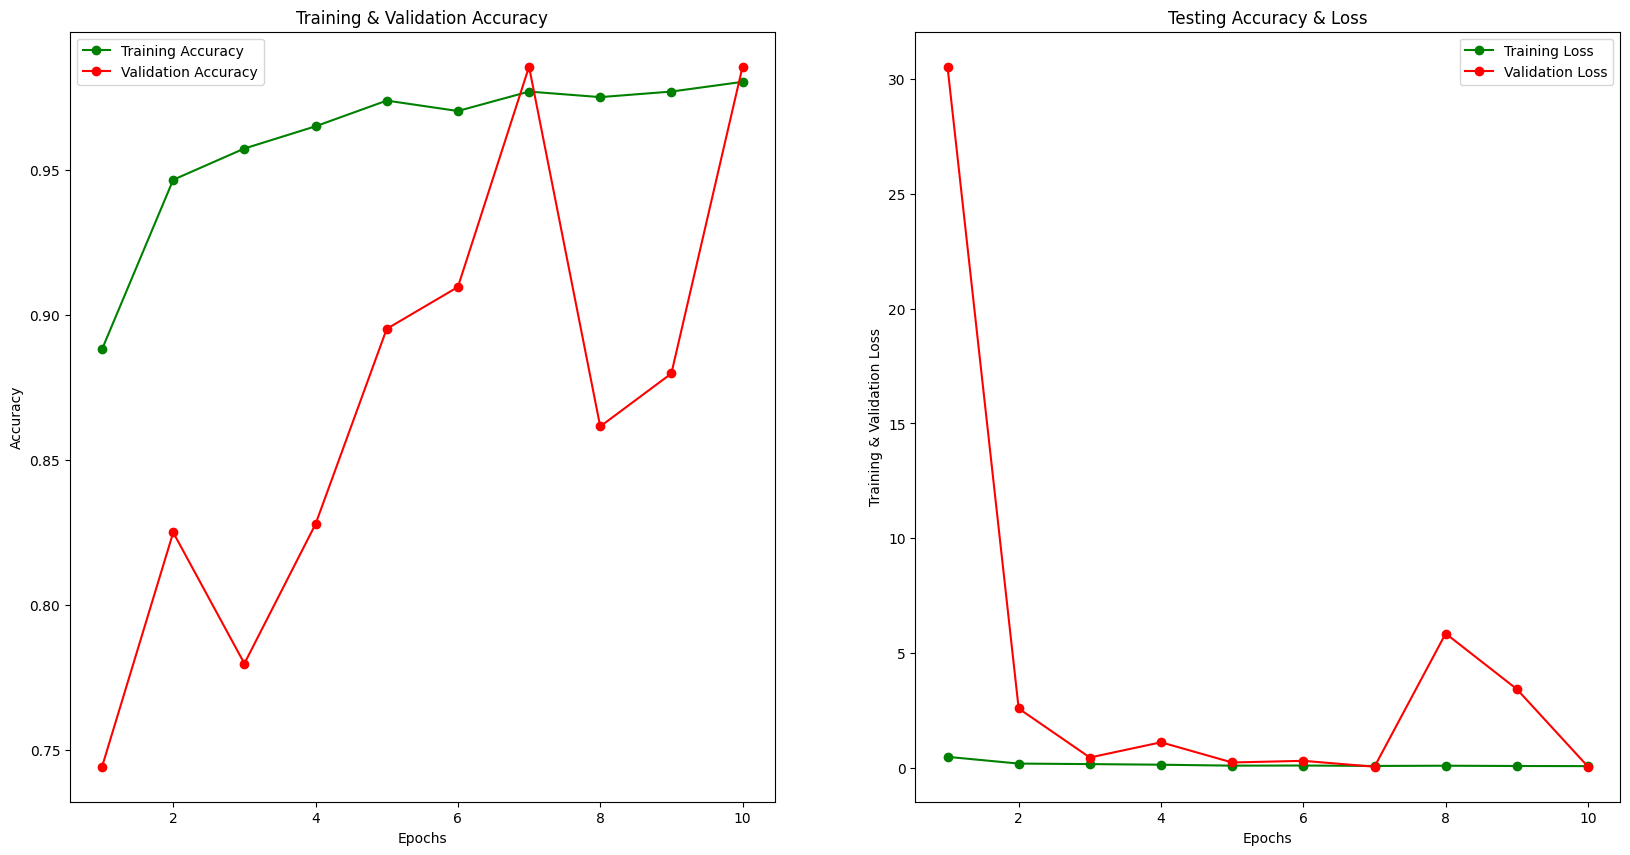

In [ ]:
epochs = [i + 1 for i in range(10)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Validation Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'r-o' , label = 'Validation Loss')
ax[1].set_title('Testing Accuracy & Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Training & Validation Loss")
plt.show()

# Realizando predicciones

In [ ]:
predictions = model.predict(test_ds)
#predictions = predictions.reshape(1,-1)[0]
#predictions[:15]

39/39 [==============================] - 16s 400ms/step


In [ ]:
loss, acc = model.evaluate(test_ds)

39/39 [==============================] - 12s 303ms/step - loss: 7.7382 - accuracy: 0.6779
